In [1]:
import pandas as pd
import json
import re
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import pprint
import warnings
warnings.simplefilter('ignore')
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import plotly.express as px
from matplotlib import pyplot as plt
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import time
from sklearn.cluster import KMeans

In [2]:
# load in parsed recipe dataset 
df_recipes= pd.read_csv('./final/final_parsed.csv')
df_recipes['ingredients_parsed'] = df_recipes.ingredients_parsed.values.astype('U')

# TF-IDF feature extractor 
tfidf = TfidfVectorizer()
tfidf.fit(df_recipes['ingredients_parsed'])
tfidf_recipe = tfidf.transform(df_recipes['ingredients_parsed'])

In [3]:
df_recipes.columns

Index(['Unnamed: 0', 'cuisines', 'dish', 'ingredients_lists', 'id', 'image',
       'ingredients', 'instructions', 'readyInMinutes', 'servings', 'title',
       'Carbohydrates g', 'Calories kcal', 'Fat g', 'Protein g',
       'ingredients_parsed'],
      dtype='object')

In [4]:
tfidf_recipe

<632x621 sparse matrix of type '<class 'numpy.float64'>'
	with 5083 stored elements in Compressed Sparse Row format>

# Perform dimensional reduction before K Means Clustering

In [5]:
pca = PCA(n_components=5)
X = pca.fit_transform(tfidf_recipe.todense())

<AxesSubplot:>

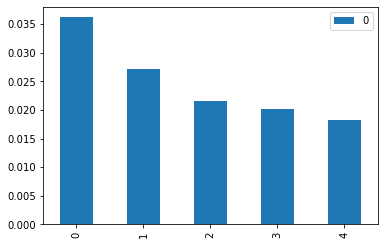

In [6]:
pca_df=pd.DataFrame(pca.explained_variance_ratio_)
pca_df.plot.bar()

# Estimate n_clusters using Elbow Method

Fit 2 clusters
Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters
Fit 11 clusters
Fit 12 clusters
Fit 13 clusters
Fit 14 clusters
Fit 15 clusters
Fit 16 clusters
Fit 17 clusters
Fit 18 clusters
Fit 19 clusters
Fit 20 clusters


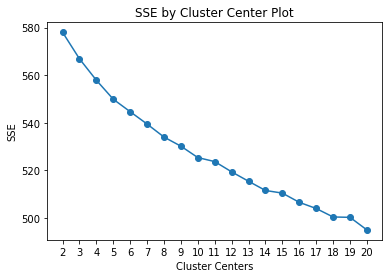

In [7]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 1)
    
    sse = []
    for k in iters:
        sse.append(KMeans(n_clusters=k, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(tfidf_recipe, 20)

In [8]:
##From cluster plot, there seems to be no change in direction of plot,So we choose cluster number=10 as a best fit

In [9]:
model = KMeans(n_clusters=10, random_state=20)
clusters=model.fit_predict(tfidf_recipe)

In [10]:
df_recipes['clusters']=clusters
df_recipes

,Unnamed: 0,cuisines,dish,ingredients_lists,id,image,ingredients,instructions,readyInMinutes,servings,title,Carbohydrates g,Calories kcal,Fat g,Protein g,ingredients_parsed,clusters
0,8,"['Mediterranean', 'Italian', 'European']",1,"['broccolini', 'garlic clove', 'olive oil', 'o...",715769,https://spoonacular.com/recipeImages/715769-31...,"{'broccolini': '0.5 bunch', 'garlic clove': '0...",In a large pan with lid heat olive oil over me...,30,2,Broccolini Quinoa Pilaf,71.66,625.07,30.69,19.86,broccolini garlic onion quinoa vegetable walnut,1
1,12,Italian,1,"['artichoke', 'bay leaf', 'coriander seeds', '...",648257,https://spoonacular.com/recipeImages/648257-31...,"{'artichoke': '1.0 pound', 'bay leaf': '1.0 ',...",Snip the thorns off the artichoke leaves.Place...,35,1,Italian Steamed Artichokes,49.50,221.45,0.82,15.21,artichoke garlic,1
2,16,Italian,1,"['crusty bread', 'mushrooms', 'spinach', 'chic...",1095745,https://spoonacular.com/recipeImages/1095745-3...,"{'crusty bread': '0.25 loaf', 'mushrooms': '0....","To make the hummus, place all ingredients in a...",30,4,Mushroom Hummus Crostini,76.92,468.07,9.76,21.49,bread mushroom spinach chickpea garlic lemon t...,9
3,20,Italian,1,"['balsamic vinegar', 'extra virgin olive oil',...",658753,https://spoonacular.com/recipeImages/658753-31...,"{'balsamic vinegar': '0.5 tablespoons', 'extra...",Slice the bread on a bias about 1/2 inch thick...,45,4,Roma Tomato Bruschetta,67.36,466.44,16.31,13.70,bread garlic tomato,1
4,24,Italian,1,"['balsamic vinegar', 'brussels sprouts', 'extr...",658515,https://spoonacular.com/recipeImages/658515-31...,"{'balsamic vinegar': '0.25 tablespoon', 'bruss...",Heat oven to 450 degrees. Trim bottom of Bruss...,45,4,Roasted Brussels Sprouts With Garlic,16.15,232.48,18.01,5.82,brussels sprout garlic,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627,817,"['Indian', 'Asian']",1,"['capsicums', 'fresh mint leaves', 'green chil...",645769,https://spoonacular.com/recipeImages/645769-31...,"{'capsicums': '1.0 servings', 'fresh mint leav...",Remove heads and shells from prawns but leave ...,45,4,Grilled Masala Prawns With Pineapple-Mint Raita,14.58,208.24,15.96,2.83,capsicum tumeric yoghurt pineapple,1
628,818,"['Indian', 'Asian']",0,"['low fat yogurt', 'water', 'green chilli', 's...",660959,https://spoonacular.com/recipeImages/660959-31...,"{'low fat yogurt': '50.0 milliliters', 'water'...",Whisk yogurt with water until well-mixed.Add c...,45,4,Spiced Lassi,5.92,42.48,0.93,2.91,yogurt shallot ice,8
629,819,"['Indian', 'Asian']",0,"['wheat flour', 'all purpose flour', 'onion', ...",651186,https://spoonacular.com/recipeImages/651186-31...,"{'wheat flour': '0.25 cups', 'all purpose flou...",Heat 2tsp of oil in a pan add mustard seeds an...,45,8,Masala Roti/chapati( Spiced Indian Flat Bread),37.76,198.50,2.59,5.30,wheat flour flour onion masala,8
630,820,"['Indian', 'Asian']",0,"['flour', 'greek yogurt', 'baking powder', 'sa...",1450327,https://spoonacular.com/recipeImages/1450327-3...,"{'flour': '0.5 cups', 'greek yogurt': '0.31 cu...",Preheat oven to 350 degrees F.Mix together the...,30,4,Simple Garlic Butter Naan,51.50,444.82,20.70,13.14,flour greek yogurt garlic butter,8


In [11]:
df_recipes.to_csv('./final/recipe_kmeans.csv')

In [12]:
#plotting k-means clustering

label_dict={'Cluster 0':"Mushroom",
            'Cluster 1':"Asian Vegetarian",
            'Cluster 2':"Italian",
            'Cluster 3':"Baked/Bread",
            'Cluster 4':"Fish,coconut",
            'Cluster 5':"Lamb",
            'Cluster 6':"Italian,Chicken",
            'Cluster 7':"Thai",
            'Cluster 8':"Breakfast/Oats",
            'Cluster 9':"Fish"}


trace_Kmeans = go.Scatter(x=X[:, 0], y= X[:, 1], mode="markers",
                    showlegend=True,
                    
                    text = df_recipes['title'],
                    hoverinfo = 'text',
                    #legendgrouptitle=label_dict,
                    marker=dict(
                            size=8,
                            color = clusters,
                            colorscale = 'Portland',
                            showscale=False, 
                            line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        )
                   ))
layout = dict(title = 'KMeans Clustering',
              hovermode= 'closest',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False),
              #hoverlabel=label_dict,
              showlegend= False,
              width=600,
              height=600,
             )

data = [trace_Kmeans]
fig1 = dict(data=data, layout= layout)#,mapping=label_dict)
#fig1.add_trace(go.Scatter(label_dict))
# fig1.append_trace(contour_list)
py.iplot(fig1, filename="svm")
fig1 =px.scatter(x=range(10), y=range(10))
fig1.write_html("./kmeans_plot.html")

In [13]:
def get_top_keywords(data,clusters, labels, n_terms):
    try:
        df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    except:
        df=data
    cluster_dict={}
    for i,r in df.iterrows():
        #print('\nCluster {}'.format(i))
        #print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
        cluster_dict['Cluster {}'.format(i)]=[labels[t] for t in np.argsort(r)[-n_terms:]]
        
    return pd.DataFrame(cluster_dict)   
        
cluster_df=get_top_keywords(tfidf_recipe,clusters, tfidf.get_feature_names(), 10)
cluster_df

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9
0,mushroom,curry,parmesan,powdered,masala,carrot,cheddar,wine,maple,flour
1,yogurt,masala,cheese,cream,chilies,wine,cream,garlic,banana,egg
2,thigh,avocado,kidney,yeast,tomato,pea,chicken,onion,syrup,salmon
3,butter,potato,garlic,orange,potato,tomato,onion,scallion,oat,butter
4,wine,vegetable,chicken,banana,fish,yogurt,garlic,fish,wheat,fish
5,lemon,wine,celery,milk,onion,lemon,tomato,sugar,yogurt,onion
6,tomato,bread,carrot,butter,garlic,onion,egg,chicken,butter,wine
7,onion,garlic,onion,egg,curry,potato,mozzarella,rice,milk,garlic
8,garlic,onion,tomato,flour,milk,garlic,parmesan,sesame,egg,fillet
9,chicken,tomato,bean,sugar,coconut,lamb,cheese,soy,flour,lemon


In [14]:
cluster_df.to_csv('./final/cluster_df', index=False)

In [15]:
str_input=df_recipes.ingredients_parsed.to_list()

def cluster_predict(str_input):
    Y = tfidf.transform(list(str_input))
    cluster_nums = model.predict(Y)
    cluster_num=np.random.choice(cluster_nums)
    return cluster_num
#cluster_predict(['paneer','tomato','spinach'])

def recipe_predict(df_recipes,cluster_num,dish_type,min_time=5,max_time=60):
    if dish_type=='main dish':
        dish_type=1
    else:
        dish_type=0
    recipe_cluster=df_recipes[(df_recipes['clusters']==cluster_num)&(df_recipes['dish']==dish_type)]
    #print(recipe_cluster)
    recipe_title=recipe_cluster[(recipe_cluster['readyInMinutes']>=min_time) & (recipe_cluster['readyInMinutes']<=max_time)][['title','ingredients','instructions','readyInMinutes','servings']]#.head(3)#.values
    #print(time_recipe)
    #recipe_ingredients=recipe_cluster[(recipe_cluster['readyInMinutes']>=min_time) & (recipe_cluster['readyInMinutes']<=max_time)]['ingredients'].values
    #recipe_title=time_recipe[time_recipe['Calories kcal']==time_recipe['Calories kcal'].min()]['title']
    #print(recipe_title)
    return recipe_title#,recipe_ingredients
#recipe_predict(df_recipes,0,'main dish',20,40) 

def recommender(str_input,dish_type,min_time=5,max_time=60):
    data=df_recipes
    cluster_num=cluster_predict(str_input)
    recipe_title=recipe_predict(data,cluster_num,dish_type,min_time,max_time)
    return recipe_title#['title']
#recommender(['avocado','tomato','red onion'],'main dish')

In [16]:
recommender(['fish','tomato','red onion'],'main dish')

,title,ingredients,instructions,readyInMinutes,servings
78,Thai Pizza,"{'all purpose flour': '0.67 cups', 'broccoli':...",Bring out your Crockpot/Slow Cooker and line i...,45,3
130,"Cauliflower, Brown Rice, and Vegetable Fried Rice","{'broccoli': '0.25 cups', 'cauliflower': '0.13...",Remove the cauliflower's tough stem and reserv...,30,8
136,Broccoli and Chickpea Rice Salad,"{'almonds': '0.04 cup', 'broccoli florets': '0...","In a large skillet, heat the oil over medium h...",45,6
147,Quinoa Salad with Vegetables and Cashews,"{'brussels sprouts': '0.25 cups', 'carrots': '...",Line a baking sheet with parchment paper and p...,45,6
160,Easy Ginger Beef Broccoli,"{'broccoli': '1.0 cups', 'chicken broth': '2.6...","In a small bowl, combine flour, broth, sugar, ...",45,4
208,Gluten Free Dairy Free Sugar Free Chinese Chic...,"{'apple cider vinegar': '0.83 ml', 'black pepp...","For the salad:Finely slice the red, and green ...",45,6
218,Chicken Satay,"{'chicken meat': '125.0 grams', 'chilli powder...",Soak 20 bamboo skewers for at least 2 hours in...,45,4
220,Chicken Lo Mein,"{'bean sprouts': '0.5 cup', 'bok choy': '0.5 c...","In a large nonstick skillet, heat oil; add gin...",45,2
232,Chicken Spring Rolls,"{'broccoli slaw': '3.0 oz', 'garlic clove': '0...","Marinate the chicken with soy sauce, garlic, a...",45,4
241,Chicken Rou Zao With Rice,"{'chicken thigh': '0.25 pound', 'shallots': '0...",Wrap and tie star anise and cloves in cheese c...,45,4


In [17]:
# Save machine learning model
filename = 'final_model.bin'
pickle.dump(model, open(filename, 'wb'))

In [18]:
###Creating word cloud of ingredeints

In [19]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

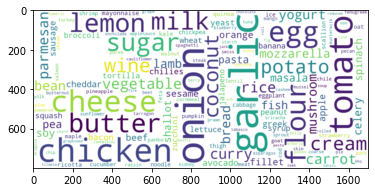

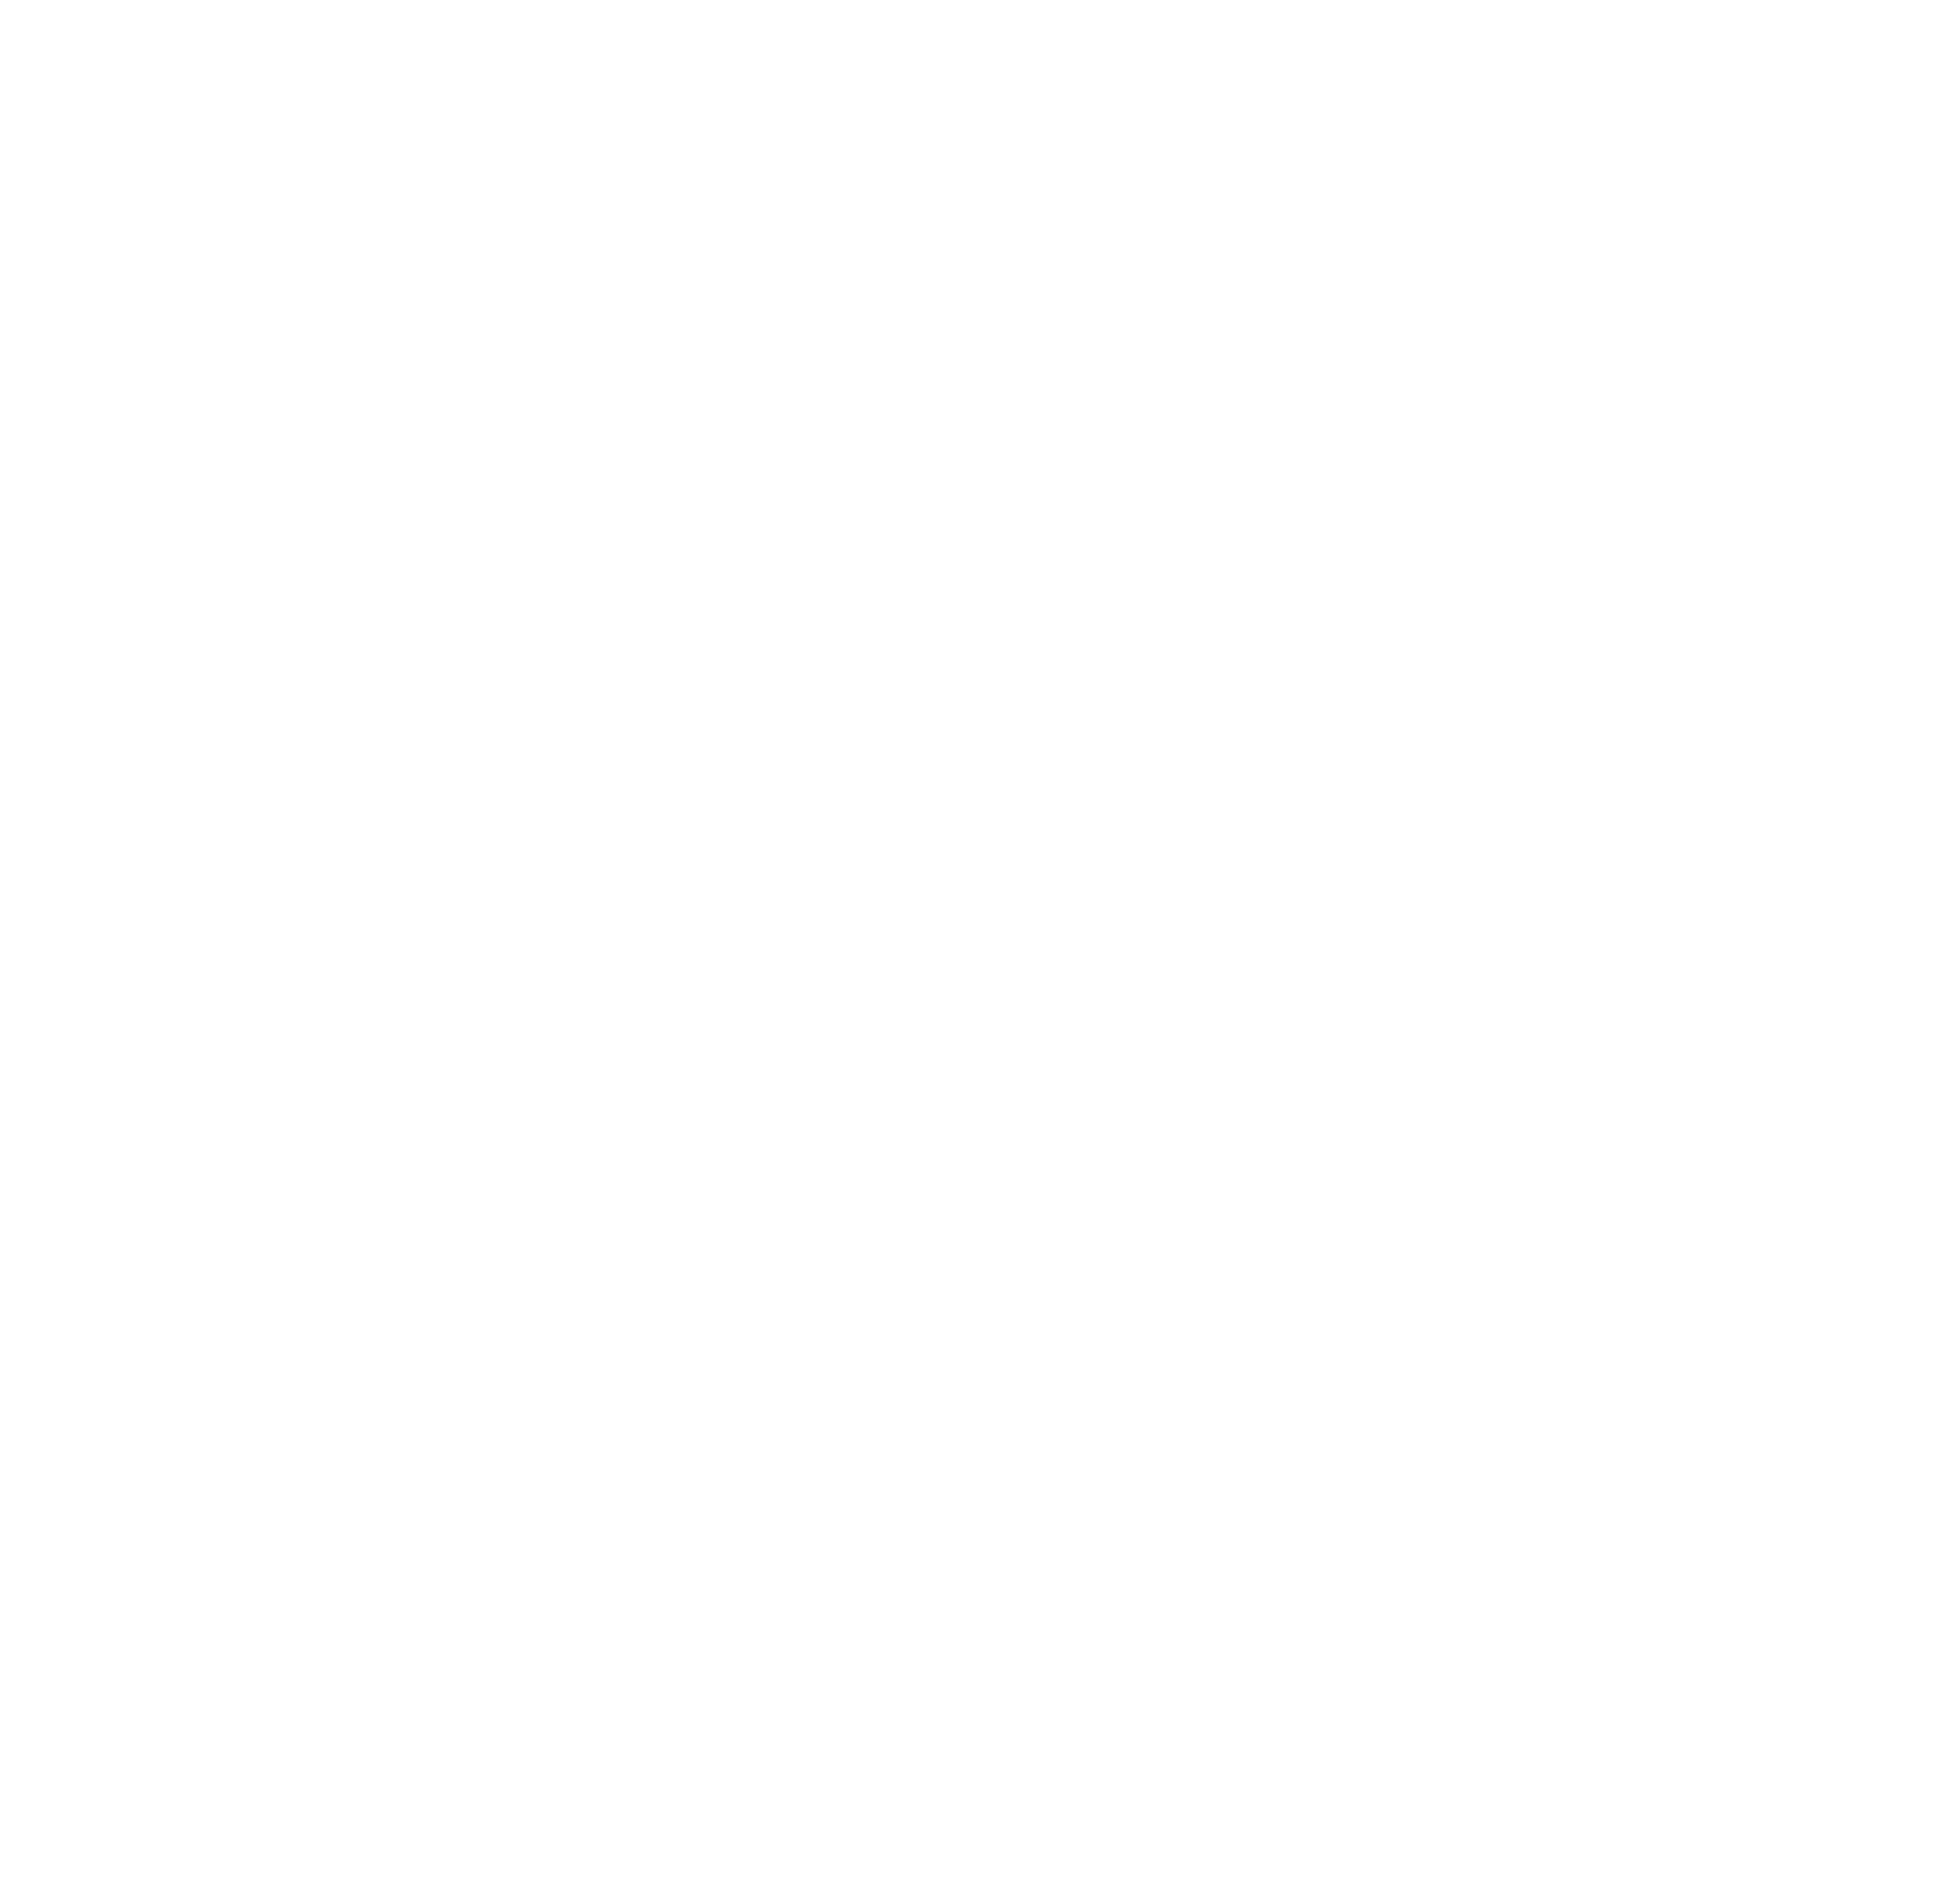

In [20]:
# Create and generate a word cloud image:
import numpy as np
from matplotlib import pyplot as plt
import wordcloud
text =" ".join(item for item in df_recipes['ingredients_parsed'])
mask = np.ndarray((800,1700, 3), np.uint8)
mask[150:350,150:350,:] = 255  # masked out area
wordcloud = WordCloud(mask=mask,
                collocations= False,  # calculates frequencies
                contour_color='steelbluemax',
                max_words=150, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(figsize=[40,40])
plt.axis("off")
plt.show()
wordcloud.to_file("./ingredeints.png")